# Experimenting of modeling protein data

In this experiment, we transform data in order to obtain a good result for its modeling with an Epsilon-Support Vector Regression (SVR) with RBF kernel. We assess its performance by predicting never seen data.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Loading data

In this first section, we load data and select the target variable (the processing time), and also drop some unused variables (protein name and result file size).

In [2]:
from sklearn.model_selection import train_test_split

def load_data(filename):
    data_df = pd.read_csv(filename)
    print("Data shape: %d x %d" % (data_df.shape))
    
    # target variable
    y = data_df['processingTime']
    # drop some variables
    X = data_df.drop(['protein', 'processingTime', 'resultSize'], axis=1)
    
    return (X, y)

We divide data into two sets: train and test.

In [3]:
X, y = load_data('whole.csv')

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=0)

Data shape: 753 x 7


## Transforming variables

In this section, we transform some variables: first, we transform the categorical variable 'machineType' into numerical; then, we scale the numerical variables to mean=0 and stdev=1.

In [4]:
categorical_features = X_train.select_dtypes(include=['object']).columns
numerical_features = X_train.select_dtypes(exclude=['object']).columns

In [5]:
from sklearn.preprocessing import LabelEncoder

label_enc = LabelEncoder()

X_train.loc[:, 'machineType'] = label_enc.fit_transform(X_train['machineType'])
X_test.loc[:, 'machineType'] = label_enc.transform(X_test['machineType'])

/home/fausto/.local/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [6]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

X_train.loc[:, numerical_features] = std_scaler.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = std_scaler.transform(X_test.loc[:, numerical_features])

## Modeling an SVR

In this section, we first define the score functions:
* R^2 (R-squared): 0 is the worse, and 1 is the better.
* RMSE (root mean squared error): the lesser the better.

We model and SVR with train set, then assess its performance by predicting never seen data (test set).

In [7]:
from sklearn.metrics import r2_score, mean_squared_error

def regr_scoring(regr, X_test, y_test):
    y_true, y_pred = y_test, regr.predict(X_test)
    
    # R^2 score: higher (1), better
    print("R^2 score on new data: %f" % r2_score(y_true, y_pred))
    
    # RMSE score: lesser (0), better
    print("RMSE on new data: %f" % np.sqrt(mean_squared_error(y_true, y_pred)))

In [8]:
from sklearn.svm import SVR

# setting parameters for SVR
svm = SVR(kernel='rbf', C=1e6)

# modeling
svm.fit(X_train, y_train)

# assessing predict performance
regr_scoring(svm, X_test, y_test)

R^2 score on new data: 0.997020
RMSE on new data: 70.505679


## Plotting predictions

In this section, we plot the predicted values obtained by the SVR versus the true values. Note the points are into a diagonal line, with few variability -- it shows the predictions are very close to the expected values. 

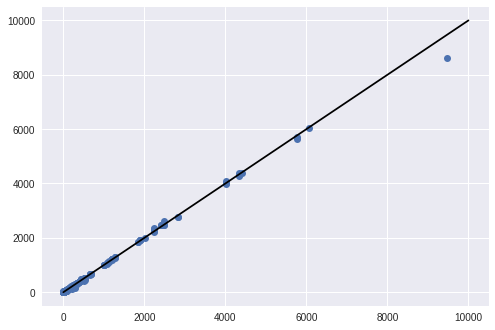

In [9]:
pred_regr, true_regr = svm.predict(X_test), y_test

plt.plot(pred_regr, true_regr, 'o')
plt.plot([0, 10000], [0, 10000], 'k-')
plt.show()

## Choosing machine type for a new experiment

Suppose a new experiment is requested, with the variables:
* chainSize: 72
* population: 80
* generations: 200

Which machine would be the best?

For this, we will use the obtained model to predict the processing time for every type of machine. Therefore, we create three experiments, each one for a type of machine:

In [46]:
new_experiment = [{'chainSize': 72, 'population': 80, 'generations': 200, 'machineType': 'Local'},
                  {'chainSize': 72, 'population': 80, 'generations': 200, 'machineType': 'Cluster'},
                  {'chainSize': 72, 'population': 80, 'generations': 200, 'machineType': 'Cloud'}]

new_experiment_df = pd.DataFrame(new_experiment)

new_experiment_df

,chainSize,generations,machineType,population
0,72,200,Local,80
1,72,200,Cluster,80
2,72,200,Cloud,80


Don't forget to transform the variables:
* Categorical variable machineType to numerical;
* Scale the numerical variables.

In [47]:
new_experiment_df.loc[:, 'machineType'] = label_enc.transform(new_experiment_df['machineType'])
new_experiment_df.loc[:, numerical_features] = std_scaler.transform(new_experiment_df.loc[:, numerical_features])

new_experiment_df

,chainSize,generations,machineType,population
0,0.183805,-0.87168,2,-0.912447
1,0.183805,-0.87168,1,-0.912447
2,0.183805,-0.87168,0,-0.912447


Finally, we can predict the processing time for each experiment.

In this case, we note the fastest machine type for processing this experiment would be the 'cluster' or 'cloud', which obtained close values.

In [48]:
svm.predict(new_experiment_df)

array([ 1673.3448569 ,   784.89068479,   806.26959227])